In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.6.0


## Hyperparameters


In [2]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## 대한항공 주가와 환율, 유가 데이터 로드 

In [3]:
ka_path = '/content/koreanAir-stock-data-1980-2021.csv'

df = pd.read_csv(ka_path, delimiter=',')

# Replace 0 to avoid dividing by 0 later on
df['vol'].replace(to_replace=0, method='ffill', inplace=True) # 일시적으로만 0을 대체
df.sort_values('date', inplace=True)
df.drop(['section', 'code', 'name', 'value', 'n_stock', 'agg_price', 'foreign_vol', 'agency_netbuy'], axis = 1, inplace= True) 
df

,date,open,high,low,close,vol,foreign_rate,agency_buy
0,19801004,808,815,806,806,5050,0.00,0
1,19801006,790,805,764,782,7904,0.00,0
2,19801007,780,780,745,745,7449,0.00,0
3,19801008,738,740,727,733,12071,0.00,0
4,19801010,726,727,712,719,8257,0.00,0
...,...,...,...,...,...,...,...,...
10931,20210818,28700,29400,28500,29200,1473161,10.79,19848
10932,20210819,28900,29100,28400,28400,1758907,10.80,-303606
10933,20210820,28400,28650,27300,27600,2550946,10.82,-184698
10934,20210823,27600,29000,27550,28700,1899431,10.92,174864


In [4]:
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Foreign', 'Agency'] 
df

,Date,Open,High,Low,Close,Volume,Foreign,Agency
0,19801004,808,815,806,806,5050,0.00,0
1,19801006,790,805,764,782,7904,0.00,0
2,19801007,780,780,745,745,7449,0.00,0
3,19801008,738,740,727,733,12071,0.00,0
4,19801010,726,727,712,719,8257,0.00,0
...,...,...,...,...,...,...,...,...
10931,20210818,28700,29400,28500,29200,1473161,10.79,19848
10932,20210819,28900,29100,28400,28400,1758907,10.80,-303606
10933,20210820,28400,28650,27300,27600,2550946,10.82,-184698
10934,20210823,27600,29000,27550,28700,1899431,10.92,174864


In [54]:
oil_path_1 = '/content/ex_ratio.csv' 
oil_path_2 = '/content/ex_ratio2.csv' 
df1 = pd.read_csv(oil_path_1, delimiter=',') 
df2 = pd.read_csv(oil_path_2, delimiter=',')  
df_oil = pd.concat([df1, df2], ignore_index = True) 
def date_change(ss):
  ans = ''
  for s in ss:
    if s.isdigit():
      ans+=s 
  return int(ans) 
def close_change(ss):
  ans = ''
  for s in ss:
    if s != ',':
      ans+=s 
  return ans
df_oil['날짜'] = df_oil['날짜'].apply(date_change) 
df_oil.drop_duplicates(['날짜'], inplace= True)
df_oil.drop(['오픈', '고가', '저가', '변동 %'], axis =1, inplace= True) 
df_oil.columns = ['Date', 'Close']  
df_oil['Close'] = df_oil['Close'].apply(close_change) 
df_oil['Close'] = df_oil['Close'].apply(pd.to_numeric)
df_oil.sort_values(by = ['Date'], inplace= True, ignore_index= True)  
df_oil

,Date,Close
0,19900726,715.35
1,19900727,715.15
2,19900730,715.20
3,19900731,713.90
4,19900801,713.15
...,...,...
8092,20210819,1176.28
8093,20210820,1175.15
8094,20210822,1175.24
8095,20210823,1169.36


In [55]:
dollar_path_1 = '/content/dollar_1.csv' 
dollar_path_2 = '/content/dollar_2.csv' 
dollar_path_3 = '/content/dollar_3.csv'  
df1 = pd.read_csv(dollar_path_1, delimiter=',') 
df2 = pd.read_csv(dollar_path_2, delimiter=',')  
df3 = pd.read_csv(dollar_path_3, delimiter=',')   
df_12 = pd.concat([df1, df2], ignore_index= True) 
df_ex = pd.concat([df_12, df3], ignore_index= True) 
df_ex['날짜'] = df_ex['날짜'].apply(date_change)
df_ex.drop_duplicates(['날짜'], inplace= True) 
df_ex.drop(['오픈', '고가', '저가', '변동 %'], axis =1, inplace= True)  
df_ex.columns = ['Date', 'Close']  
df_ex['Close'] = df_ex['Close'].apply(close_change) 
df_ex['Close'] = df_ex['Close'].apply(pd.to_numeric)
df_ex.sort_values(by = ['Date'], inplace= True, ignore_index= True)
df_ex['Close'] = df_ex['Close'].apply(pd.to_numeric)
df_ex

,Date,Close
0,19810414,676.70
1,19810415,676.70
2,19810416,676.70
3,19810417,676.75
4,19810420,676.70
...,...,...
10409,20210819,1176.28
10410,20210820,1175.15
10411,20210822,1175.24
10412,20210823,1169.36


## Plot daily 대한항공 closing prcie and volume


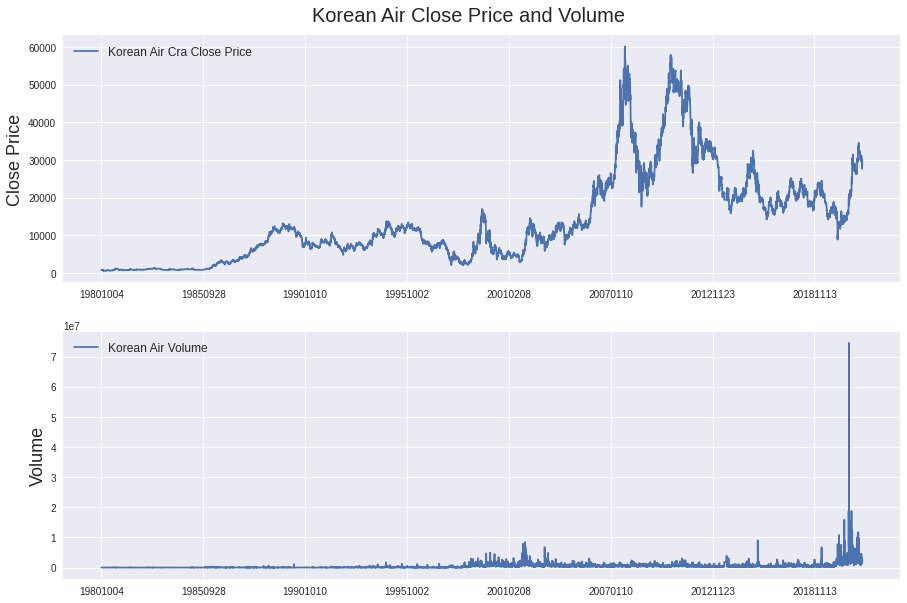

In [32]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Korean Air Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label= 'Korean Air Cra Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Korean Air Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Plot WTI index and exchange ratio

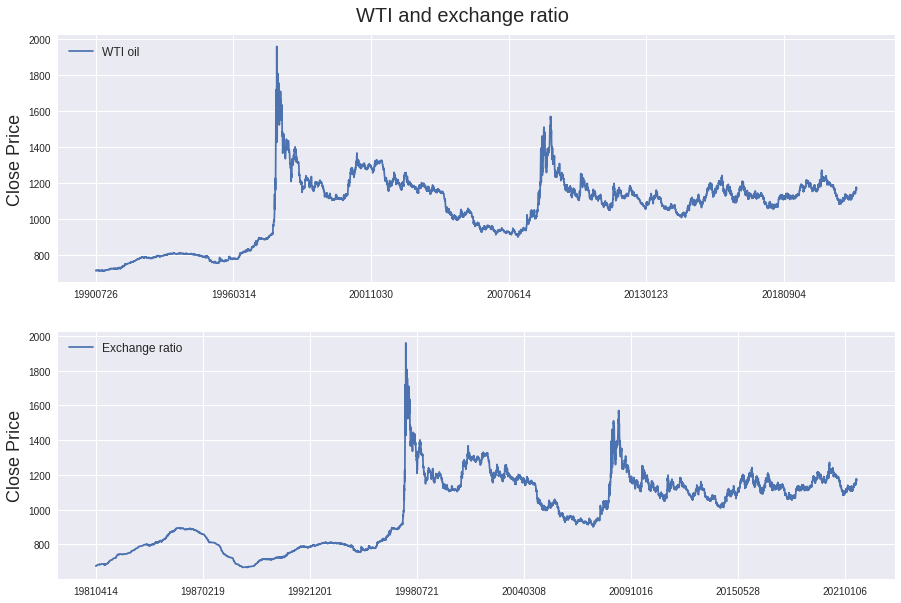

In [56]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("WTI and exchange ratio", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df_oil['Close'], label='WTI oil')
ax1.set_xticks(range(0, df_oil.shape[0], 1464))
ax1.set_xticklabels(df_oil['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df_ex['Close'], label='Exchange ratio')
ax2.set_xticks(range(0, df_ex.shape[0], 1464))
ax2.set_xticklabels(df_ex['Date'].loc[::1464])
ax2.set_ylabel('Close Price', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns
